In [2]:
import os
import numpy as np
from itertools import islice
import pandas as pd

path = './sims/output/'
extension = '.mco'
dirs = [e.name for e in os.scandir(path)]

wls = np.arange(740, 902, 2)
bin_size = 0.05
dists = np.arange(99)*bin_size
reflectance_lines = 99 # ignore the overflow bin
reflectance_col_header = "Rd_r #Rd[0], [1],..Rd[nr-1]. [1/cm2]\n"

def read_reflectance_data(folder):
    file_names = [folder + '_' + str(e) for e in range(len(wls))]

    result = np.zeros((len(wls), len(dists)))

    for i in range(len(wls)):
        with open(path + folder + '/' + file_names[i] + extension) as lines:
            read_file = lines.readlines()
            col_i = read_file.index(reflectance_col_header)
            result[i, :] = np.genfromtxt(read_file[col_i+1:col_i+reflectance_lines+1])
    
    return result

reflectances = {}
for dir in dirs:
    reflectances[dir] = read_reflectance_data(dir)

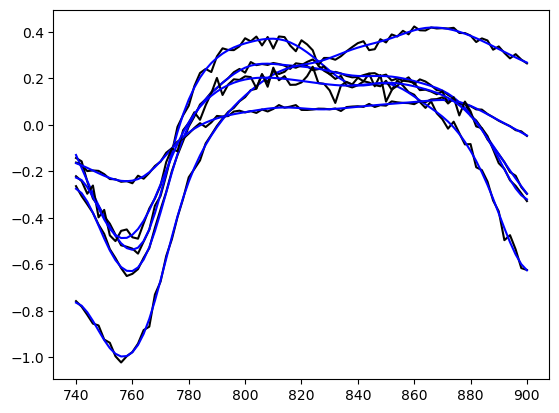

In [3]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline
from scipy.optimize import approx_fprime

degree = 3
n_knots = 14
central_knots = np.linspace(min(wls), max(wls), n_knots)
knots = np.r_[[min(wls)]*3, central_knots, [max(wls)]*3]

n_grads = 50
gradient_knots = np.linspace(min(wls), max(wls), 5)

def transform_data(y):
    y_prime = np.log(y)
    y_prime = y_prime - np.mean(y_prime)
    return y_prime

plt.figure()
for key, e in islice(reflectances.items(), 5):
    y = transform_data(e[:, 50])
    spline = make_lsq_spline(wls, y, t=knots)
    
    plt.plot(wls, y, color='black')
    plt.plot(wls, spline(wls), color='blue')

plt.show()

(array([46., 49., 39., 45., 66., 58., 52., 54., 72., 69., 69., 71., 62.,
        62., 69., 74., 67., 73., 65., 62., 69., 61., 72., 53., 56., 50.,
        51., 53., 50., 52., 48., 50., 45., 35., 30., 33., 21., 21., 26.]),
 array([ 1.01699907,  3.54094396,  6.06488884,  8.58883373, 11.11277862,
        13.63672351, 16.16066839, 18.68461328, 21.20855817, 23.73250306,
        26.25644794, 28.78039283, 31.30433772, 33.82828261, 36.35222749,
        38.87617238, 41.40011727, 43.92406216, 46.44800704, 48.97195193,
        51.49589682, 54.01984171, 56.54378659, 59.06773148, 61.59167637,
        64.11562126, 66.63956614, 69.16351103, 71.68745592, 74.21140081,
        76.73534569, 79.25929058, 81.78323547, 84.30718036, 86.83112524,
        89.35507013, 91.87901502, 94.40295991, 96.92690479, 99.45084968]),
 <BarContainer object of 39 artists>)

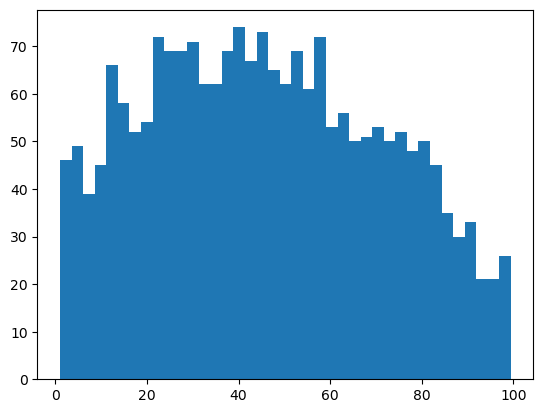

In [26]:
plt.hist(df['blood_one'], np.linspace(min(df['blood_one']), max(df['blood_one']), 40))

In [10]:
from sklearn.linear_model import LassoLarsIC

def generate_summary_statistics(distances, suffixes):
    summary_statistics = {k: {} for k in dirs}
    for key, e in reflectances.items():
        ys = [e[:, dist] for dist in distances]
        y_primes = [transform_data(y) for y in ys]

        splines = [make_lsq_spline(wls, y, t=knots) for y in ys]

        coeffs = np.array([y.c for y in splines])

        # spline coeffs for fits to y_prime
        for suffix, coeff in zip(suffixes, coeffs):
            summary_statistics[key]['spline_' + suffix] = coeff
        
        # gradients of spline fits at central_knots
        for suffix, y in zip(suffixes, splines):
            summary_statistics[key]['spline_gradient_' + suffix] = np.diag(approx_fprime(gradient_knots, y))
        
        # log(mean) of y
        for suffix, y in zip(suffixes, ys):
            summary_statistics[key]['log_mean_' + suffix] = np.log(np.mean(y))
            summary_statistics[key]['mean_' + suffix] = np.mean(y)
            summary_statistics[key]['variance_' + suffix] = np.var(np.log(y))
            summary_statistics[key]['minimax_' + suffix] = np.array([np.max(y), np.min(y)])
            summary_statistics[key]['minimaxwl_' + suffix] = np.array([wls[np.argmax(y)], wls[np.argmin(y)]])
    
    return summary_statistics

def run_whole_thing(distances, df, target_col):
    suffixes = [str(e) for e in range(len(distances))]
    summary_statistics = generate_summary_statistics(distances, suffixes)

    def build_summary_stat_x(uuid):
        summary = summary_statistics[uuid]
        summary_stats = [np.atleast_1d(summary[key + '_' + suffix]) for key in ['log_mean', 'variance', 'spline'] for suffix in suffixes] + [summary[key] for key in []]
        extra_powers = [2, 3]
        base_stats = np.concatenate(summary_stats)
        return np.concatenate([base_stats] + [np.power(base_stats, e) for e in extra_powers])
    
    df['oxy_blood_two'] = df['blood_two']*df['blood_sat_two']
    df['deoxy_blood_two'] = df['blood_two']*(1 - df['blood_sat_two'])
    df = df[[target_col, 'uuid']]

    df = df[df.loc[:, 'uuid'].apply(lambda uuid: uuid in reflectances)]
    df.loc[:, 'x'] = df.loc[:, 'uuid'].apply(build_summary_stat_x)

    y = np.zeros(len(df))
    mat = np.zeros((len(df), len(df['x'].iloc[0])))

    print('mat shape:', mat.shape)

    for i, (_, row) in enumerate(df.iterrows()):
        y[i] = row[target_col]
        mat[i, :] = row['x']

    model = LassoLarsIC(normalize=True).fit(mat, y)

    print("fit model with alpha_:", model.alpha_)
    print("AIC = ", np.min(model.criterion_))
    print(model.coef_)
    
    # matrix eqn y = mat @ beta

    #beta = np.linalg.pinv(mat) @ y
    beta = model.coef_

    # model y as mat @ beta

    summary_stat = mat @ beta

    df.loc[:, 'summary_stat'] = df.loc[:, 'x'].apply(lambda x: np.sum(x * beta))

    return y, summary_stat, df

mat shape: (327, 54)
fit model with alpha_: 2.424219869616837e-05
AIC =  1990.9295996508163
[-6.85704490e+01  1.22678577e+02  3.80173620e+03  2.89316042e+03
 -2.36851561e+03 -8.26678041e+03 -3.91372734e+03  0.00000000e+00
  3.05036191e+03  2.00088823e+03  1.54470073e+03  6.66288072e+03
  1.52158065e+03 -1.16404656e+03 -6.98435901e+03  0.00000000e+00
  0.00000000e+00  3.34360896e+03  0.00000000e+00 -5.22276801e+03
 -7.60030857e+03  0.00000000e+00  0.00000000e+00  3.01673855e+04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.16176748e+04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.01052942e+04
  0.00000000e+00 -1.17308012e+03 -3.48513359e+02 -7.27740856e+03
  0.00000000e+00  1.75058825e+05  0.00000000e+00 -1.43699724e+04
 -1.26260396e+04 -5.00480802e+04  3.18705409e+04  2.85530804e+04
  0.00000000e+00  0.00000000e+00 -3.95272781e+04 -1.77440772e+04
  0.00000000e+00  0.00000000e+00  8.03664519e+04  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


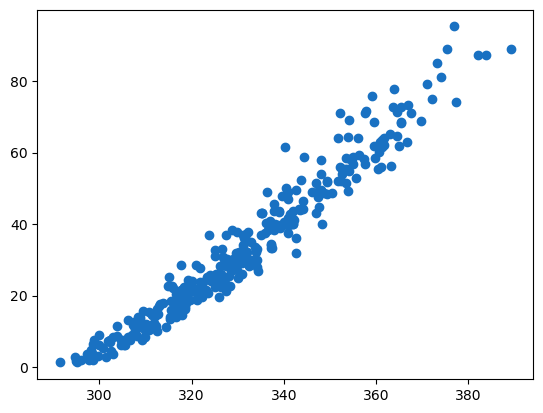

In [20]:
from constants.colors import colours

df = pd.read_csv('./sims/df.csv', index_col=0)

target = 'deoxy_blood_two'
y, summary_stat, df_ = run_whole_thing([10], df, target)

plt.figure()
plt.scatter(df_['summary_stat'], df_[target], color=colours['blue'][8])
plt.show()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
        1., 2., 1., 6., 4., 6., 4., 2., 6., 3., 1., 0., 1., 0., 1., 2., 0.,
        1., 0., 0., 2., 1.]),
 array([0.        , 0.02564103, 0.05128205, 0.07692308, 0.1025641 ,
        0.12820513, 0.15384615, 0.17948718, 0.20512821, 0.23076923,
        0.25641026, 0.28205128, 0.30769231, 0.33333333, 0.35897436,
        0.38461538, 0.41025641, 0.43589744, 0.46153846, 0.48717949,
        0.51282051, 0.53846154, 0.56410256, 0.58974359, 0.61538462,
        0.64102564, 0.66666667, 0.69230769, 0.71794872, 0.74358974,
        0.76923077, 0.79487179, 0.82051282, 0.84615385, 0.87179487,
        0.8974359 , 0.92307692, 0.94871795, 0.97435897, 1.        ]),
 <BarContainer object of 39 artists>)

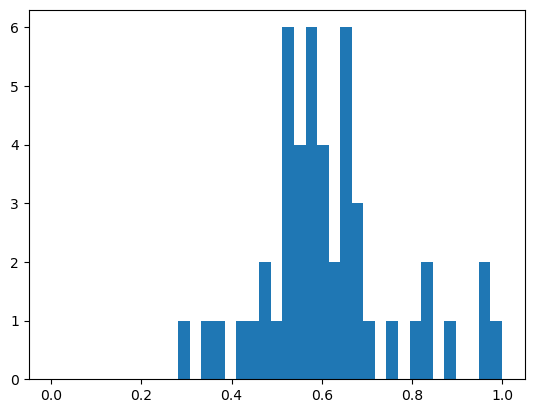

In [ ]:
eps = 0.05
target = 0.6

in_range = df.query(f'{target - eps} < summary_stat < {target + eps}')

plt.figure()
plt.hist(in_range[target_col], np.linspace(0, 1, 40))